In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("Customers.csv",delimiter=";",decimal=",",index_col=0)
df.head(10)

,Profit,Recency,Frequency,Monetary,Variance
CustomerId,,,,,
1,187,63,1,2349.06,2
2,96,10,6,922.62,4
3,47,35,4,881.22,3
4,294,5,1,3815.16,2
5,732,4,31,41868.11,29
6,37,16,3,2053.40,8
7,264,11,12,4861.49,12
8,188,4,8,4010.69,9
9,316,4,21,12636.80,20


In [3]:
# wartości wyglądają ok
df.describe()

,Profit,Recency,Frequency,Monetary,Variance
count,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000
mean,1102.391132,15.847121,10.710126,1.753805e+05,16.673064
std,5457.675137,19.051823,10.348786,1.791089e+06,17.704351
min,1.000000,1.000000,1.000000,7.290000e+00,1.000000
25%,79.000000,4.000000,3.000000,1.392950e+03,5.000000
50%,224.000000,6.000000,9.000000,5.799930e+03,11.000000
75%,559.500000,19.000000,14.500000,2.228900e+04,23.000000
max,105993.000000,91.000000,79.000000,3.253994e+07,139.000000


In [4]:
#nie ma żadnych null wartości
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1511 entries, 1 to 1511
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Profit     1511 non-null   int64  
 1   Recency    1511 non-null   int64  
 2   Frequency  1511 non-null   int64  
 3   Monetary   1511 non-null   float64
 4   Variance   1511 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 70.8 KB


In [5]:
#jest kilka zduplikowanych wartości ale że mają inne customerid to można to potraktować jako przypadek
print(sum(df.duplicated()))
df.loc[df.duplicated()]

13


,Profit,Recency,Frequency,Monetary,Variance
CustomerId,,,,,
516,76,5,8,878.37,6
623,319,5,12,9566.50,7
706,300,4,2,6999.14,3
734,61,12,10,1216.07,6
755,300,4,2,6999.14,3
757,300,4,2,6999.14,3
880,300,4,2,6999.14,3
882,300,4,2,6999.14,3
912,82,41,3,2460.26,5


<AxesSubplot:>

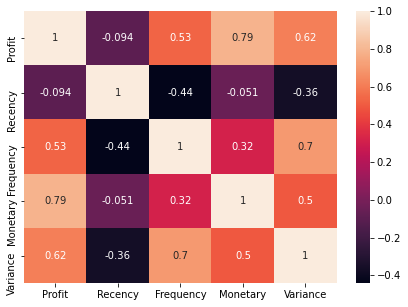

In [6]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(),annot=True)

Text(0, 0.5, 'Variance')

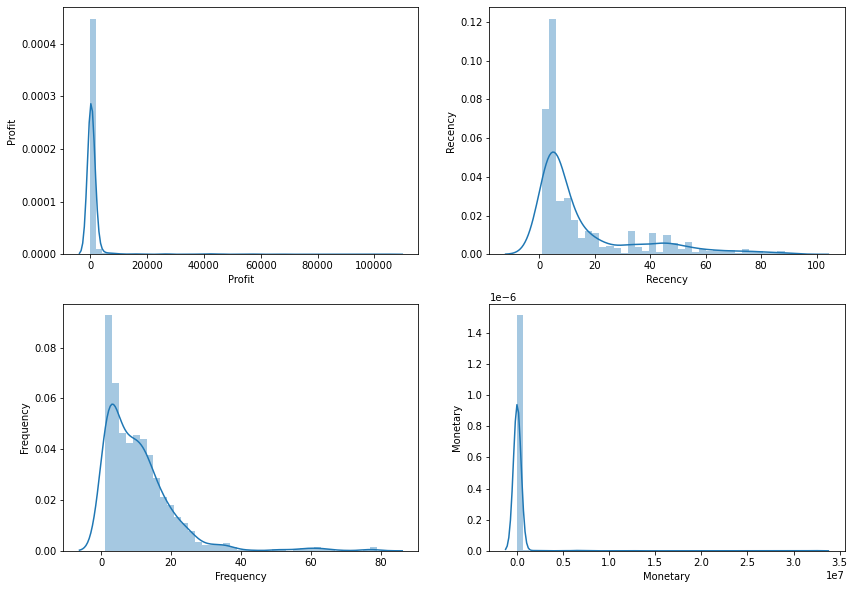

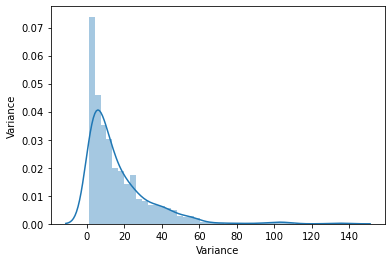

In [7]:
fig,axes=plt.subplots(2,2,figsize=(14,10))
for ax,col in zip(axes.ravel(),df.columns[:4]):
    sns.distplot(df[col],ax=ax)
    ax.set_ylabel(col)
plt.figure()
sns.distplot(df[df.columns[4]])
plt.ylabel(df.columns[4])

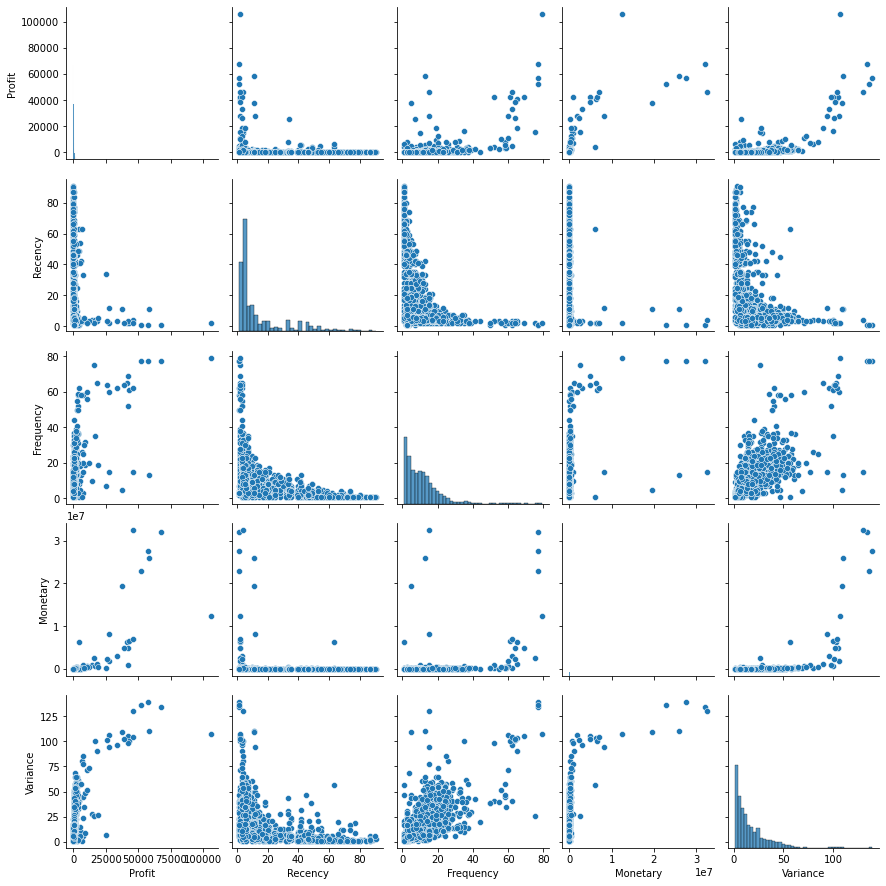

In [8]:
#widzimy że profit jest wysoki dla niskiego recency, wyższej wariancji
# natomiast frequency nie zbyt dużego wpływu na profit ale widać lekki wzrost profitu dla wyższego freq
sns.pairplot(df)

In [10]:
# możemy zastosować transformację logarytmiczną aby zmniejszyć kurtozę i skośność
for col in df.columns:
    print("\n\n"+col)
    print("skewness: {}".format(df[col].skew()))
    print("kurtosis: {}".format(df[col].kurt()))



Profit
skewness: 10.751104080026336
kurtosis: 142.95831726099985


Recency
skewness: 1.787807767797152
kurtosis: 2.443179569205675


Frequency
skewness: 2.642863354037998
kurtosis: 10.86120863653766


Monetary
skewness: 14.580271624855833
kurtosis: 227.33582481370047


Variance
skewness: 2.5089810390312848
kurtosis: 9.535427914462783


In [3]:
quantiles=df.quantile(q=[0.2,0.4,0.6,0.8])
quantiles.to_dict()

{'Profit': {0.2: 61.0, 0.4: 155.0, 0.6: 311.0, 0.8: 700.0},
 'Recency': {0.2: 4.0, 0.4: 5.0, 0.6: 10.0, 0.8: 28.0},
 'Frequency': {0.2: 3.0, 0.4: 6.0, 0.6: 11.0, 0.8: 16.0},
 'Monetary': {0.2: 1034.76, 0.4: 3528.72, 0.6: 9695.37, 0.8: 31564.75},
 'Variance': {0.2: 4.0, 0.4: 8.0, 0.6: 14.0, 0.8: 26.0}}

In [4]:
#czym wyższe wartości tym lepiej
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]:
        return 2
    else:
        return 1
    
def PFMVScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]:
        return 4
    else:
        return 5

In [5]:
prfmv_seg=df
prfmv_seg["R_quintile"]=prfmv_seg["Recency"].apply(RScore,args=("Recency",quantiles,))
prfmv_seg["P_quintile"]=prfmv_seg["Profit"].apply(PFMVScore,args=("Profit",quantiles,))
prfmv_seg["F_quintile"]=prfmv_seg["Frequency"].apply(PFMVScore,args=("Frequency",quantiles,))
prfmv_seg["M_quintile"]=prfmv_seg["Monetary"].apply(PFMVScore,args=("Monetary",quantiles,))
prfmv_seg["V_quintile"]=prfmv_seg["Variance"].apply(PFMVScore,args=("Variance",quantiles,))

In [6]:
prfmv_seg["PRFMVGroup"]=prfmv_seg.P_quintile.map(str) + prfmv_seg.R_quintile.map(str) \
                    + prfmv_seg.F_quintile.map(str) + prfmv_seg.M_quintile.map(str) \
                    + prfmv_seg.V_quintile.map(str)

In [7]:
prfmv_seg["RFMGroup"]= prfmv_seg.R_quintile.map(str) \
                    + prfmv_seg.F_quintile.map(str) + prfmv_seg.M_quintile.map(str)

In [8]:
prfmv_seg["PRFMVScore"]=prfmv_seg.P_quintile+prfmv_seg.R_quintile+ prfmv_seg.F_quintile \
                        + prfmv_seg.M_quintile + prfmv_seg.V_quintile
prfmv_seg["RFMScore"]=prfmv_seg.R_quintile + prfmv_seg.F_quintile \
                        + prfmv_seg.M_quintile

In [26]:
prfmv_seg.head()

,Profit,Recency,Frequency,Monetary,Variance,R_quintile,P_quintile,F_quintile,M_quintile,V_quintile,PRFMVGroup,RFMGroup,PRFMVScore,RFMScore
CustomerId,,,,,,,,,,,,,,
1,187,63,1,2349.06,2,1,3,1,2,1,31121,112,8,4
2,96,10,6,922.62,4,3,2,2,1,1,23211,321,9,6
3,47,35,4,881.22,3,1,1,2,1,1,11211,121,6,4
4,294,5,1,3815.16,2,4,3,1,3,1,34131,413,12,8
5,732,4,31,41868.11,29,5,5,5,5,5,55555,555,25,15


In [9]:
loyalty_level = ["Stracony - małe przychody","klient z potencjałem","wymaga uwagi","lojalny klient","VIP"]
cuts = pd.qcut(prfmv_seg['RFMScore'],q = 5,labels=loyalty_level)
prfmv_seg['RFM_Loyality_level'] = cuts.values

loyalty_level = ["stracony - małe przychody","Mały potencjał - możliwa utrata","klient z potencjałem",
                 "duży potencjał","wymaga uwagi" ,"lojalny klient","ważny klient","VIP"]
cuts = pd.qcut(prfmv_seg['PRFMVScore'],q = 8,labels=loyalty_level)
prfmv_seg['PRFMV_Loyality_level'] = cuts.values


prfmv_seg.tail(15)

,Profit,Recency,Frequency,Monetary,Variance,R_quintile,P_quintile,F_quintile,M_quintile,V_quintile,PRFMVGroup,RFMGroup,PRFMVScore,RFMScore,RFM_Loyality_level,PRFMV_Loyality_level
CustomerId,,,,,,,,,,,,,,,,
1497,148,11,6,1380.73,7,2,2,2,2,2,22222,222,10,6,klient z potencjałem,Mały potencjał - możliwa utrata
1498,6,87,1,107.04,2,1,1,1,1,1,11111,111,5,3,Stracony - małe przychody,stracony - małe przychody
1499,85,16,11,642.02,8,2,2,3,1,2,22312,231,10,6,klient z potencjałem,Mały potencjał - możliwa utrata
1500,30,55,1,127.83,1,1,1,1,1,1,11111,111,5,3,Stracony - małe przychody,stracony - małe przychody
1501,768,3,21,19567.87,18,5,5,5,4,4,55544,554,23,14,VIP,ważny klient
1502,87,4,8,1734.88,14,5,2,3,2,3,25323,532,15,10,wymaga uwagi,duży potencjał
1503,213,5,8,6547.08,18,4,3,3,3,4,34334,433,17,10,wymaga uwagi,wymaga uwagi
1504,138,19,5,2236.05,4,2,2,2,2,1,22221,222,9,6,klient z potencjałem,Mały potencjał - możliwa utrata
1505,704,3,23,5226.98,11,5,5,5,3,3,55533,553,21,13,lojalny klient,ważny klient


<Figure size 1296x4320 with 0 Axes>

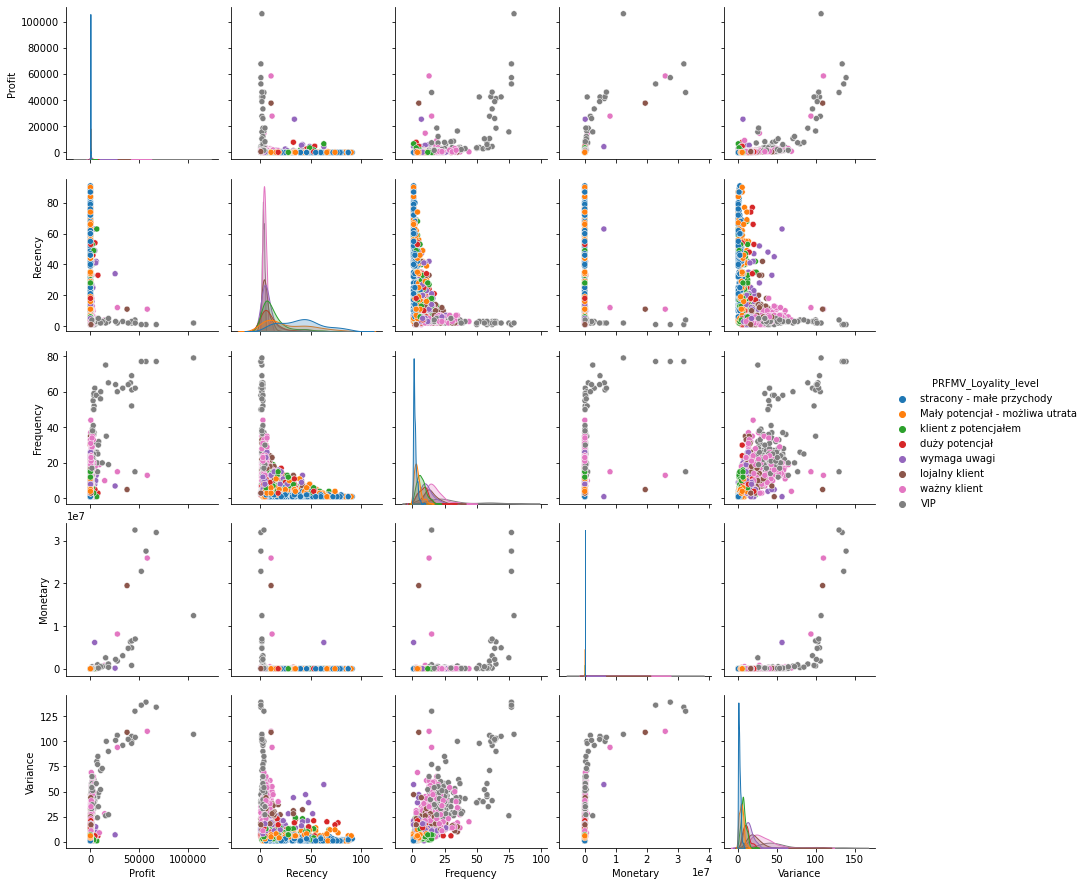

In [19]:
data_pairplot=prfmv_seg[["Profit","Recency","Frequency","Monetary","Variance","PRFMV_Loyality_level"]]
plt.figure(figsize=(18,60))
sns.pairplot(data=data_pairplot,hue="PRFMV_Loyality_level")

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

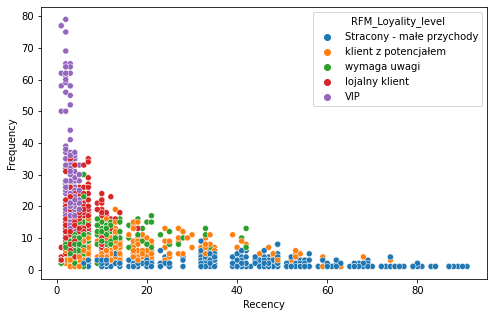

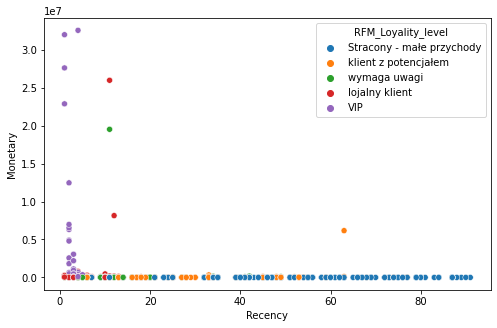

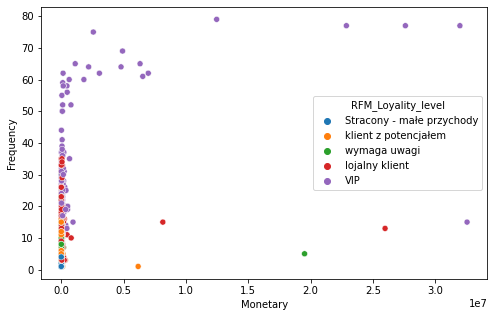

In [40]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=prfmv_seg,x="Recency",y="Frequency",hue="RFM_Loyality_level")
plt.figure(figsize=(8,5))
sns.scatterplot(data=prfmv_seg,x="Recency",y="Monetary",hue="RFM_Loyality_level")
plt.figure(figsize=(8,5))
sns.scatterplot(data=prfmv_seg,x="Monetary",y="Frequency",hue="RFM_Loyality_level")

In [27]:
#ponieważ wszystkie wartości są dodatnie możemy zastosować transformację logarytmiczną
#transformacja logarytmiczna znacznie poprawiła kurtozę i skośność
df_tf=df[["Profit","Recency","Frequency","Monetary","Variance"]].copy()
df_tf=df_tf.apply(np.log)

for col in df_tf.columns:
    print("\n\n"+col)
    print("skewness: {}".format(df_tf[col].skew()))
    print("kurtosis: {}".format(df_tf[col].kurt()))



Profit
skewness: 0.08397929686455606
kurtosis: 0.9886898758713203


Recency
skewness: 0.42190172869704473
kurtosis: -0.7144930174350157


Frequency
skewness: -0.4030474094885452
kurtosis: -0.5725960073007901


Monetary
skewness: 0.15247710784114787
kurtosis: 0.8980249477134752


Variance
skewness: -0.3638304883877028
kurtosis: -0.4684580915935337


Text(0, 0.5, 'Variance')

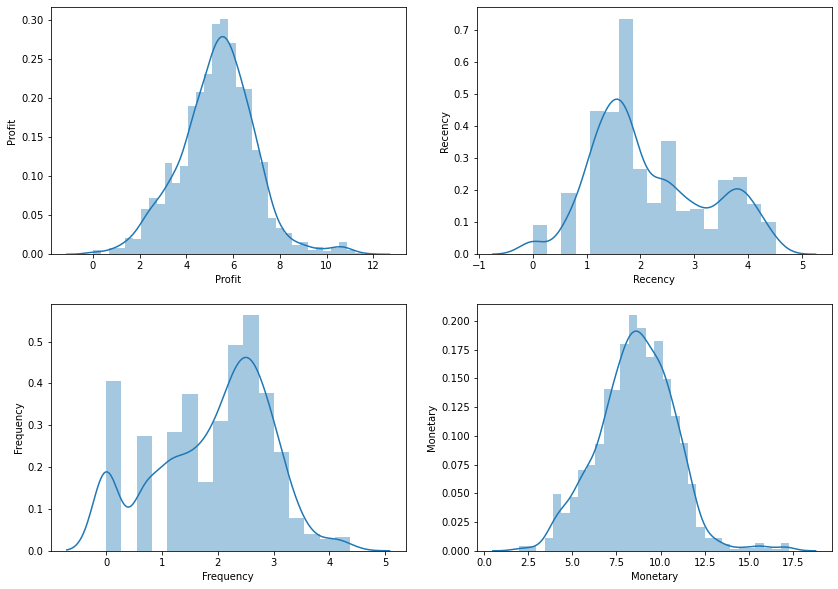

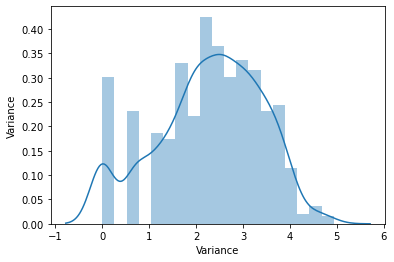

In [28]:
#wykresy bardziej przypominają rozkład normalny
fig,axes=plt.subplots(2,2,figsize=(14,10))
for ax,col in zip(axes.ravel(),df_tf.columns[:4]):
    sns.distplot(df_tf[col],ax=ax)
    ax.set_ylabel(col)
plt.figure()
sns.distplot(df_tf[df.columns[4]])
plt.ylabel(df_tf.columns[4])

Text(0, 0.5, 'inertia_')

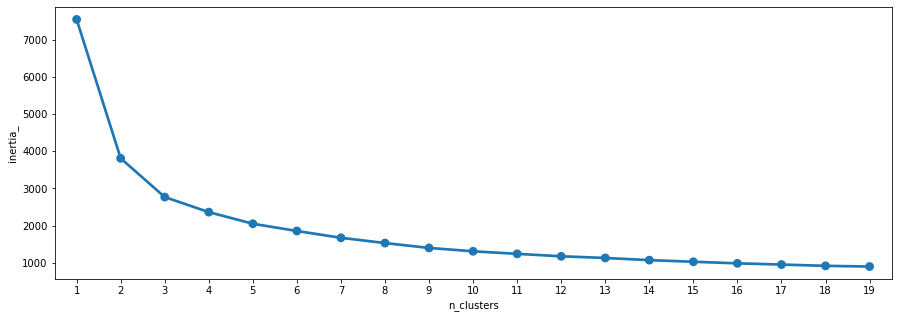

In [30]:
# na podstawie wykresu możemy dobrym wyborem n_clusters = 3 lub 4
scaler = StandardScaler()
df_tf_scaled = scaler.fit_transform(df_tf)
df_tf_scaled = pd.DataFrame(df_tf_scaled,columns=df_tf.columns,index=df_tf.index)

distances = {}
for i in range(1,20):
    kmeans = KMeans(n_clusters= i, max_iter=10000)
    kmeans = kmeans.fit(df_tf_scaled)
    distances[i] = kmeans.inertia_

# używamy "Elbow method"
plt.figure(figsize = (15,5))
sns.pointplot(x = list(distances.keys()), y = list(distances.values()))
plt.xlabel("n_clusters")
plt.ylabel("inertia_")

In [31]:
kmeans = KMeans(n_clusters=4, max_iter=10000)
kmeans = kmeans.fit(df_tf_scaled)
preds=kmeans.predict(df_tf_scaled)

<Figure size 1296x4320 with 0 Axes>

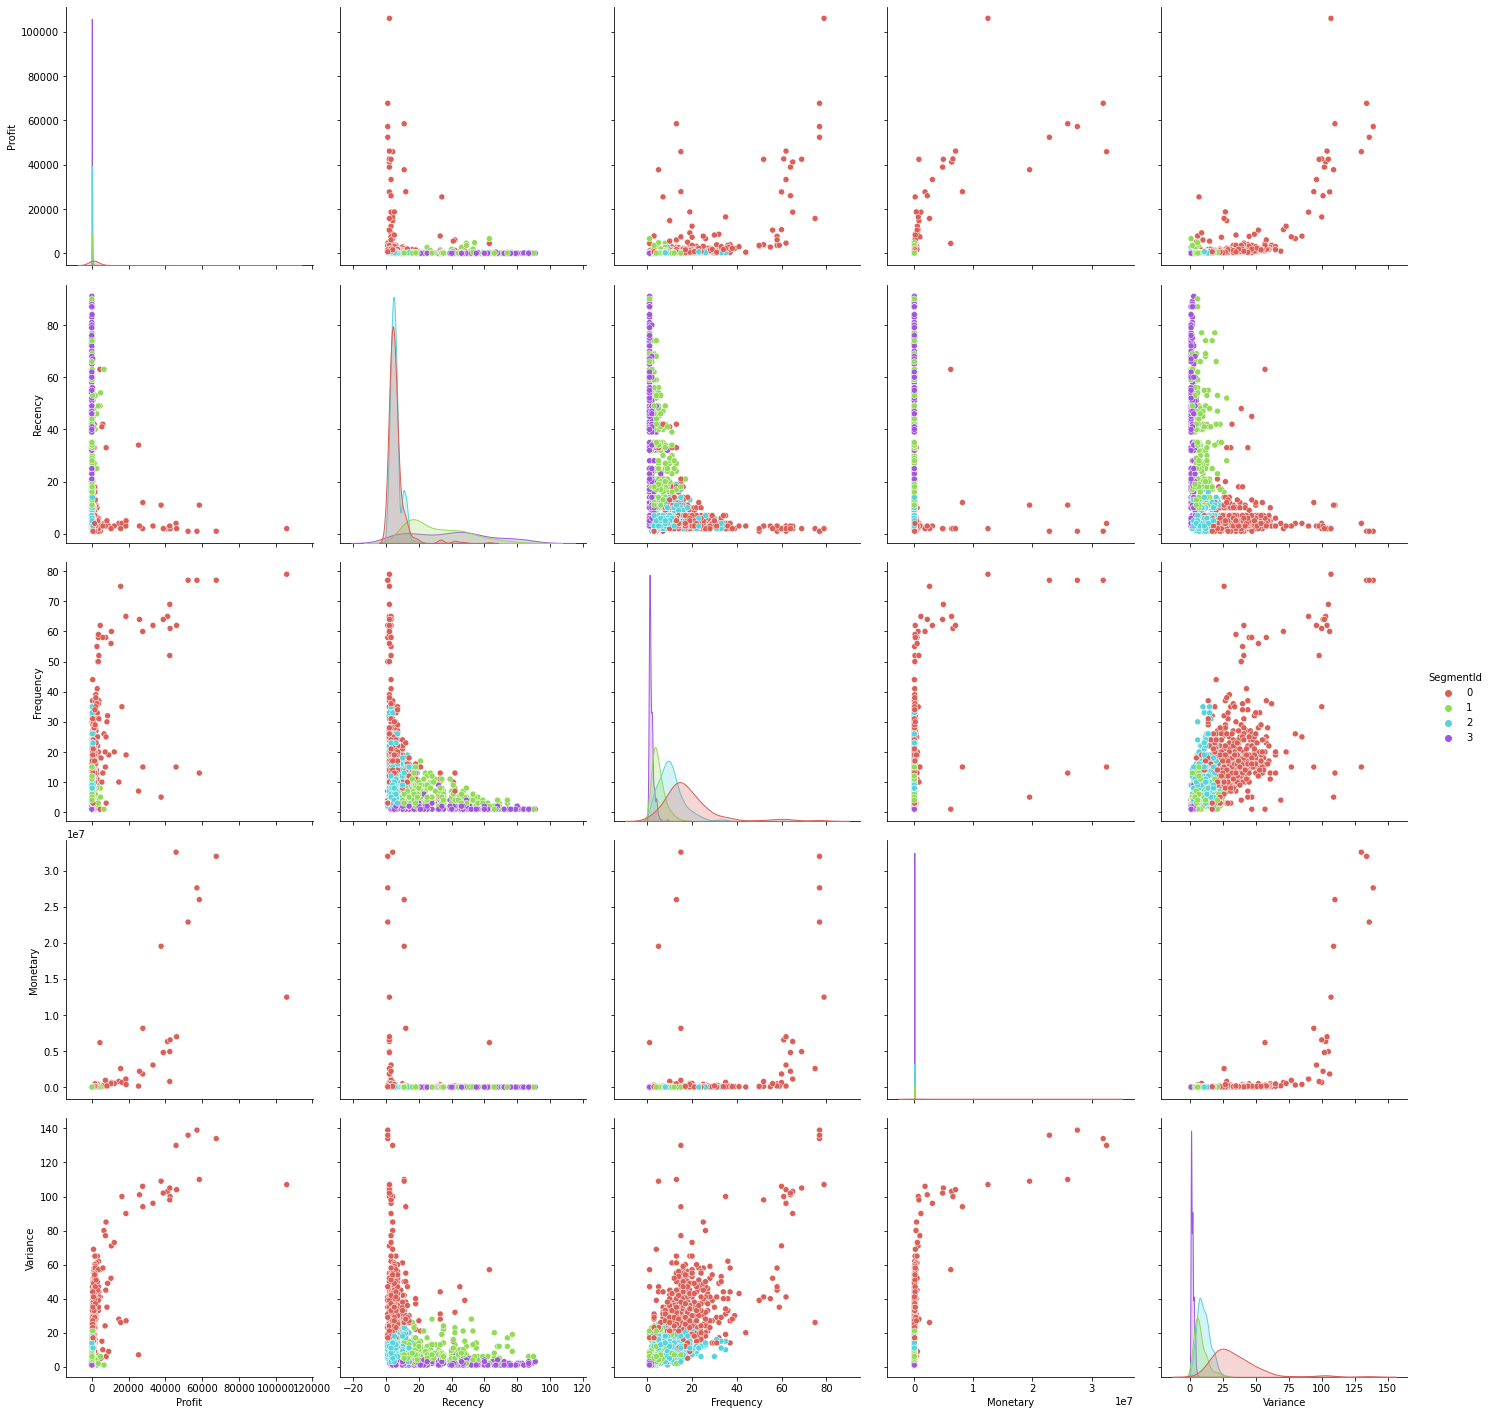

In [43]:
data_pairplot=df[["Profit","Recency","Frequency","Monetary","Variance"]].copy()
data_pairplot["SegmentId"]=preds
plt.figure(figsize=(18,60))
sns.pairplot(data=data_pairplot,hue="SegmentId",palette=sns.color_palette("hls",4),size=4)

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

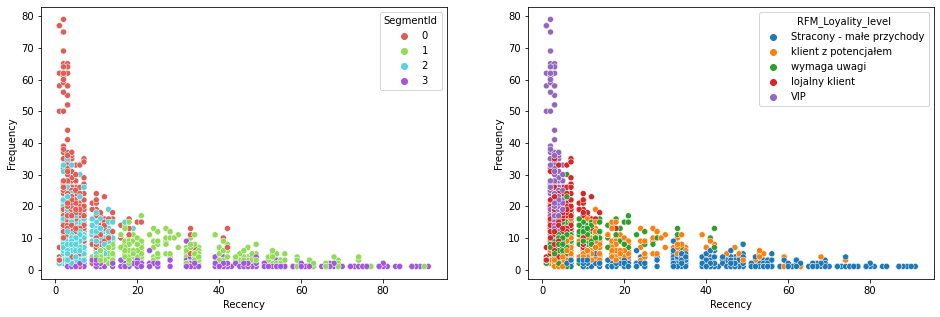

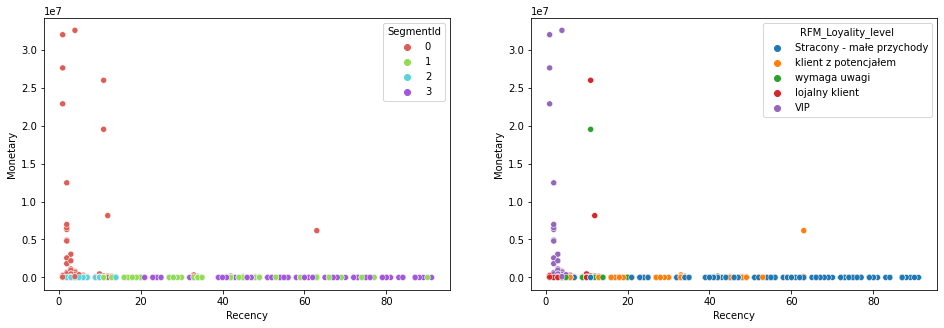

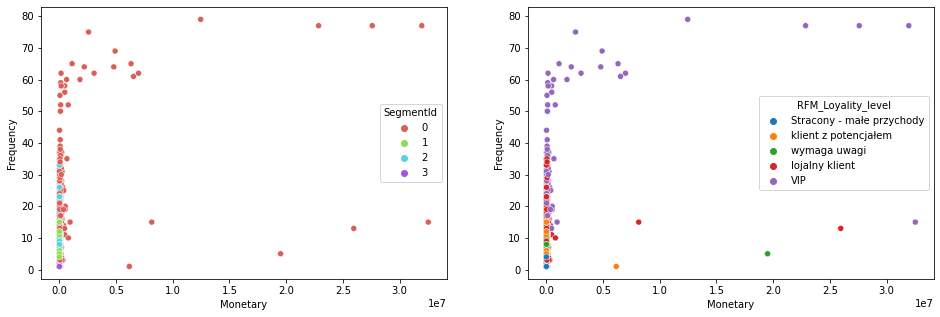

In [41]:
fig,axes=plt.subplots(1,2,figsize=(16,5))
sns.scatterplot(data=data_pairplot,x="Recency",y="Frequency",
                hue="SegmentId",palette=sns.color_palette("hls",4),ax=axes[0])
sns.scatterplot(data=prfmv_seg,x="Recency",y="Frequency",hue="RFM_Loyality_level",ax=axes[1])

fig,axes=plt.subplots(1,2,figsize=(16,5))
sns.scatterplot(data=data_pairplot,x="Recency",y="Monetary",
                hue="SegmentId",palette=sns.color_palette("hls",4),ax=axes[0])
sns.scatterplot(data=prfmv_seg,x="Recency",y="Monetary",hue="RFM_Loyality_level",ax=axes[1])

fig,axes=plt.subplots(1,2,figsize=(16,5))
sns.scatterplot(data=data_pairplot,x="Monetary",y="Frequency",
                hue="SegmentId",palette=sns.color_palette("hls",4),ax=axes[0])
sns.scatterplot(data=prfmv_seg,x="Monetary",y="Frequency",hue="RFM_Loyality_level",ax=axes[1])

In [47]:
"""
segmentid=0 - wysoki profit, wysokie frequency, male recency, wysokie monetary i variance - VIP
segmentid=1 - niski-sredni profit, niskie-srednie frequency, wysokie recency, niskie monetary,
niskie-srednie variance - klienci odchodzący / potencjalni klienci
segmentid=2 - sredni profit, srednie frequency, male recency, niskie monetary,
srednie-wysokie variance - stali klienci
segmentid=3 - niski profit, niskie frequency, niskie-wysokie recency, niskie monetary,
niskie variance - nowi / straceni klienci
"""
segment_names_unique=np.array(["VIP","Odchodzacy/Potencjalny Klient","Staly klient","Nowy/Stracony Klient"])
segment_names=segment_names_unique[data_pairplot["SegmentId"].to_numpy()]
final_df=data_pairplot.copy()
final_df["SegmentName"]=segment_names
final_df.head(20)

,Profit,Recency,Frequency,Monetary,Variance,SegmentId,SegmentName
CustomerId,,,,,,,
1,187,63,1,2349.06,2,1,Odchodzacy/Potencjalny Klient
2,96,10,6,922.62,4,1,Odchodzacy/Potencjalny Klient
3,47,35,4,881.22,3,1,Odchodzacy/Potencjalny Klient
4,294,5,1,3815.16,2,1,Odchodzacy/Potencjalny Klient
5,732,4,31,41868.11,29,0,VIP
6,37,16,3,2053.40,8,1,Odchodzacy/Potencjalny Klient
7,264,11,12,4861.49,12,2,Staly klient
8,188,4,8,4010.69,9,2,Staly klient
9,316,4,21,12636.80,20,0,VIP


In [49]:
final_df.to_csv("Florek Daniel customers.csv",sep=";",decimal=",")


In [2]:
import os
os.system('jupyter nbconvert --to html "Florek Daniel AkcjaSegmentacja.ipynb"')

0